# Mapping

In response to the 2008 U.S. Farm Bill, the U.S. Department of Agriculture's [Economic Research Service](https://www.ers.usda.gov/about-ers/) compiled a [June 2009 report to Congress](https://www.ers.usda.gov/publications/pub-details/?pubid=42729):

> According to data from the latest census (2000), about 23.5 million people, or 8.4 percent of the U.S. population, live in low-income neighborhoods that are more than a mile from a supermarket. Low-income neighborhoods are areas where more than 40 percent of the population has income less than or equal to 200 percent of the Federal poverty threshold ($44,000 per year for a family of four in 2008).

In this assessment, we'll simulate their analysis by creating geospatial maps to help us understand food access in Washington. There are three geographic region types that we'll use in this assessment:

- **Census tract** is a geographic region used in the U.S. census. It is the smallest of the three region types.
- **County** is a geographic region used for administrative purposes that can include one or more census tracts.
- **State** is a geographic region such as the State of Washington. It is the largest of the three region types.

A census tract is defined as **low access** if enough people in the tract do not have nearby access to grocery stores offering affordable and nutritious food. In urban areas, "low access" is defined as 0.5 miles; in rural areas, "low access" is defined as 10 miles.

`tl_2010_53_tract00.shp` contains the 2010 US census dataset in geospatial shapefile format only for Washington state (53). The only columns you need to use are `CTIDFP00`, the census tract identifier, and `geometry`, the geometric shape of the tract.

`food_access.csv` contains the food access dataset in tabular CSV format. Each row in the dataset corresponds to a census tract for every state in the country (not just Washington). This dataset has many columns but you only need to understand the following:

- `CensusTract` is the census tract identifier.
- `State` is the state name for the census tract.
- `County` is the county name for the census tract.
- `Urban` is a flag (0 or 1) that indicates if this census tract is an urban environment.
- `Rural` is a flag that indicates if this census tract is a rural environment.
- `LATracts_half` is a flag that indicates if this census tract is "low access" in a half mile radius.
- `LATracts10` is a flag that indicates if this census tract is "low access" in a 10 mile radius.
- `LowIncomeTracts` is a flag that indicates if this census tract is "low income".
- `POP2010` is the number of people in this census tract according to the 2010 census.
- `lapophalf` is the number of people in this census tract considered having "low access" in a half mile radius.
- `lapop10` is the number of people in this census tract considered having "low access" in a 10 mile radius.
- `lalowihalf` is similar to `lapophalf` but only counts people considered low access and low income.
- `lalowi10` is similar to `lapop10` but only counts people considered low access and low income.

In [1]:
!pip install -q folium mapclassify

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

# For testing purposes
import json
import numpy as np
from geopandas.plotting import _plot_polygon_collection
from matplotlib.collections import PatchCollection

with open("expected_idx.json") as f:
    rural_idx, rural_la_idx, urban_ha_idx, lalowi_idx = json.load(f)

class MockAxes:
    def add_collection(self, *args, **kwargs):
        pass

    def autoscale_view(self, *args, **kwargs):
        pass

def assert_patches_allclose(actual_patches, ax=MockAxes(), num_colors=None, **kwargs):
    if isinstance(kwargs.get("geoms"), str):
        kwargs["geoms"] = gpd.read_file(kwargs["geoms"]).geometry
    expected_patches = _plot_polygon_collection(ax=ax, **kwargs)
    for expected, actual in zip(expected_patches.get_paths(), actual_patches.get_paths()):
        np.testing.assert_allclose(expected.vertices, actual.vertices)
    if "color" in kwargs:
        np.testing.assert_allclose(expected_patches.get_fc(), actual_patches.get_fc())
    elif isinstance(num_colors, int):
        num_unique = len(np.unique(actual_patches.get_fc(), axis=0))
        assert num_unique == num_colors, f"expected {num_colors} colors, got {num_unique} colors"

## Task: Load in data

Write a function `load_data` that takes path for census dataset and the path for the food access dataset and returns the `GeoDataFrame` resulting from merging the two datasets on the census tract identifiers `CTIDFP00` / `CensusTract`. Assume the census tract identifier columns exist: use only these two column names. Not all census tracts have food access data.

In [2]:
def load_data(shp_path, csv_path):
    """
    This function returns the dataset that results from merging the two datasets on the two
    census tract identifiers with the given file paths. It is assumed that the census tract
    identifier column exists. Also, not all census tracts have food access data.
    """
    census = gpd.read_file(shp_path)
    food = pd.read_csv(csv_path)
    return census.merge(food, left_on="CTIDFP00", right_on="CensusTract", how="left")

state_data = load_data("tl_2010_53_tract00.shp", "food_access.csv")
display(state_data)
assert type(state_data) == gpd.GeoDataFrame
assert list(state_data.columns) == [
    "STATEFP00", "COUNTYFP00", "TRACTCE00", "CTIDFP00", "NAME00", "NAMELSAD00", "MTFCC00",
    "FUNCSTAT00", "ALAND00", "AWATER00", "INTPTLAT00", "INTPTLON00", "geometry", "CensusTract",
    "State", "County", "Urban", "Rural", "LATracts_half", "LATracts10", "GroupQuartersFlag",
    "OHU2010", "NUMGQTRS", "PCTGQTRS", "LowIncomeTracts", "POP2010", "lapophalf", "lalowihalf",
    "lapop10", "lalowi10",
]
assert len(state_data) == 1318

STATEFP00 COUNTYFP00 TRACTCE00     CTIDFP00  NAME00           NAMELSAD00  \
0           53        077    001400  53077001400      14      Census Tract 14   
1           53        077    001600  53077001600      16      Census Tract 16   
2           53        077    000700  53077000700       7       Census Tract 7   
3           53        077    002400  53077002400      24      Census Tract 24   
4           53        077    002200  53077002200      22      Census Tract 22   
...        ...        ...       ...          ...     ...                  ...   
1313        53        063    010202  53063010202  102.02  Census Tract 102.02   
1314        53        063    010301  53063010301  103.01  Census Tract 103.01   
1315        53        063    010504  53063010504  105.04  Census Tract 105.04   
1316        53        063    010303  53063010303  103.03  Census Tract 103.03   
1317        53        063    001600  53063001600      16      Census Tract 16   

     MTFCC00 FUNCSTAT00    ALAND00  AWATER00  ... GroupQuartersFlag OHU2010  \
0      G5020          S    5539748         0  ...               0.0  1203.0   
1      G5020          S   97657363   1509774  ...               NaN     NaN   
2      G5020          S    2930010         0  ...               0.0  2602.0   
3      G5020          S  232557960     69748  ...               NaN     NaN   
4      G5020          S  207645882         0  ...               0.0  2501.0   
...      ...        ...        ...       ...  ...               ...     ...   
1313   G5020          S  184070644         0  ...               0.0  2346.0   
1314   G5020          S   21667422         0  ...               0.0  1612.0   
1315   G5020          S    9371197         0  ...               0.0  1325.0   
1316   G5020          S  107033392         0  ...               0.0  1085.0   
1317   G5020          S    2104249         0  ...               0.0  1430.0   

     NUMGQTRS  PCTGQTRS LowIncomeTracts POP2010    lapophalf   lalowihalf  \
0        62.0  0.018002             1.0  3444.0  2883.838461  1594.727661   
1         NaN       NaN             NaN     NaN          NaN          NaN   
2       141.0  0.019938             1.0  7072.0  1881.362199   948.972610   
3         NaN       NaN             NaN     NaN          NaN          NaN   
4        23.0  0.002970             1.0  7745.0  6137.595205  2770.949604   
...       ...       ...             ...     ...          ...          ...   
1313      8.0  0.001146             0.0  6983.0  6842.568092   860.247108   
1314     13.0  0.003047             1.0  4266.0  3597.752448  1770.888294   
1315      0.0  0.000000             0.0  3546.0  3237.127237   517.875884   
1316     12.0  0.003971             0.0  3022.0  3022.000003   507.539103   
1317      0.0  0.000000             1.0  3738.0   145.702168    99.504575   

         lapop10   lalowi10  
0       0.000000   0.000000  
1            NaN        NaN  
2       0.000000   0.000000  
3            NaN        NaN  
4       0.000000   0.000000  
...          ...        ...  
1313  112.663119  15.763564  
1314    0.000000   0.000000  
1315    0.000000   0.000000  
1316    0.000000   0.000000  
1317    0.000000   0.000000  

[1318 rows x 30 columns]

## Task: Plot census tracts

Write a function `plot_census_map` that takes the merged data and returns the `Axes` that contains shapes of all the census tracts in Washington. Title the plot "Washington Census Tracts" and turn off axis labels. The output should look look like Washington state with zig-zagging census tract lines.

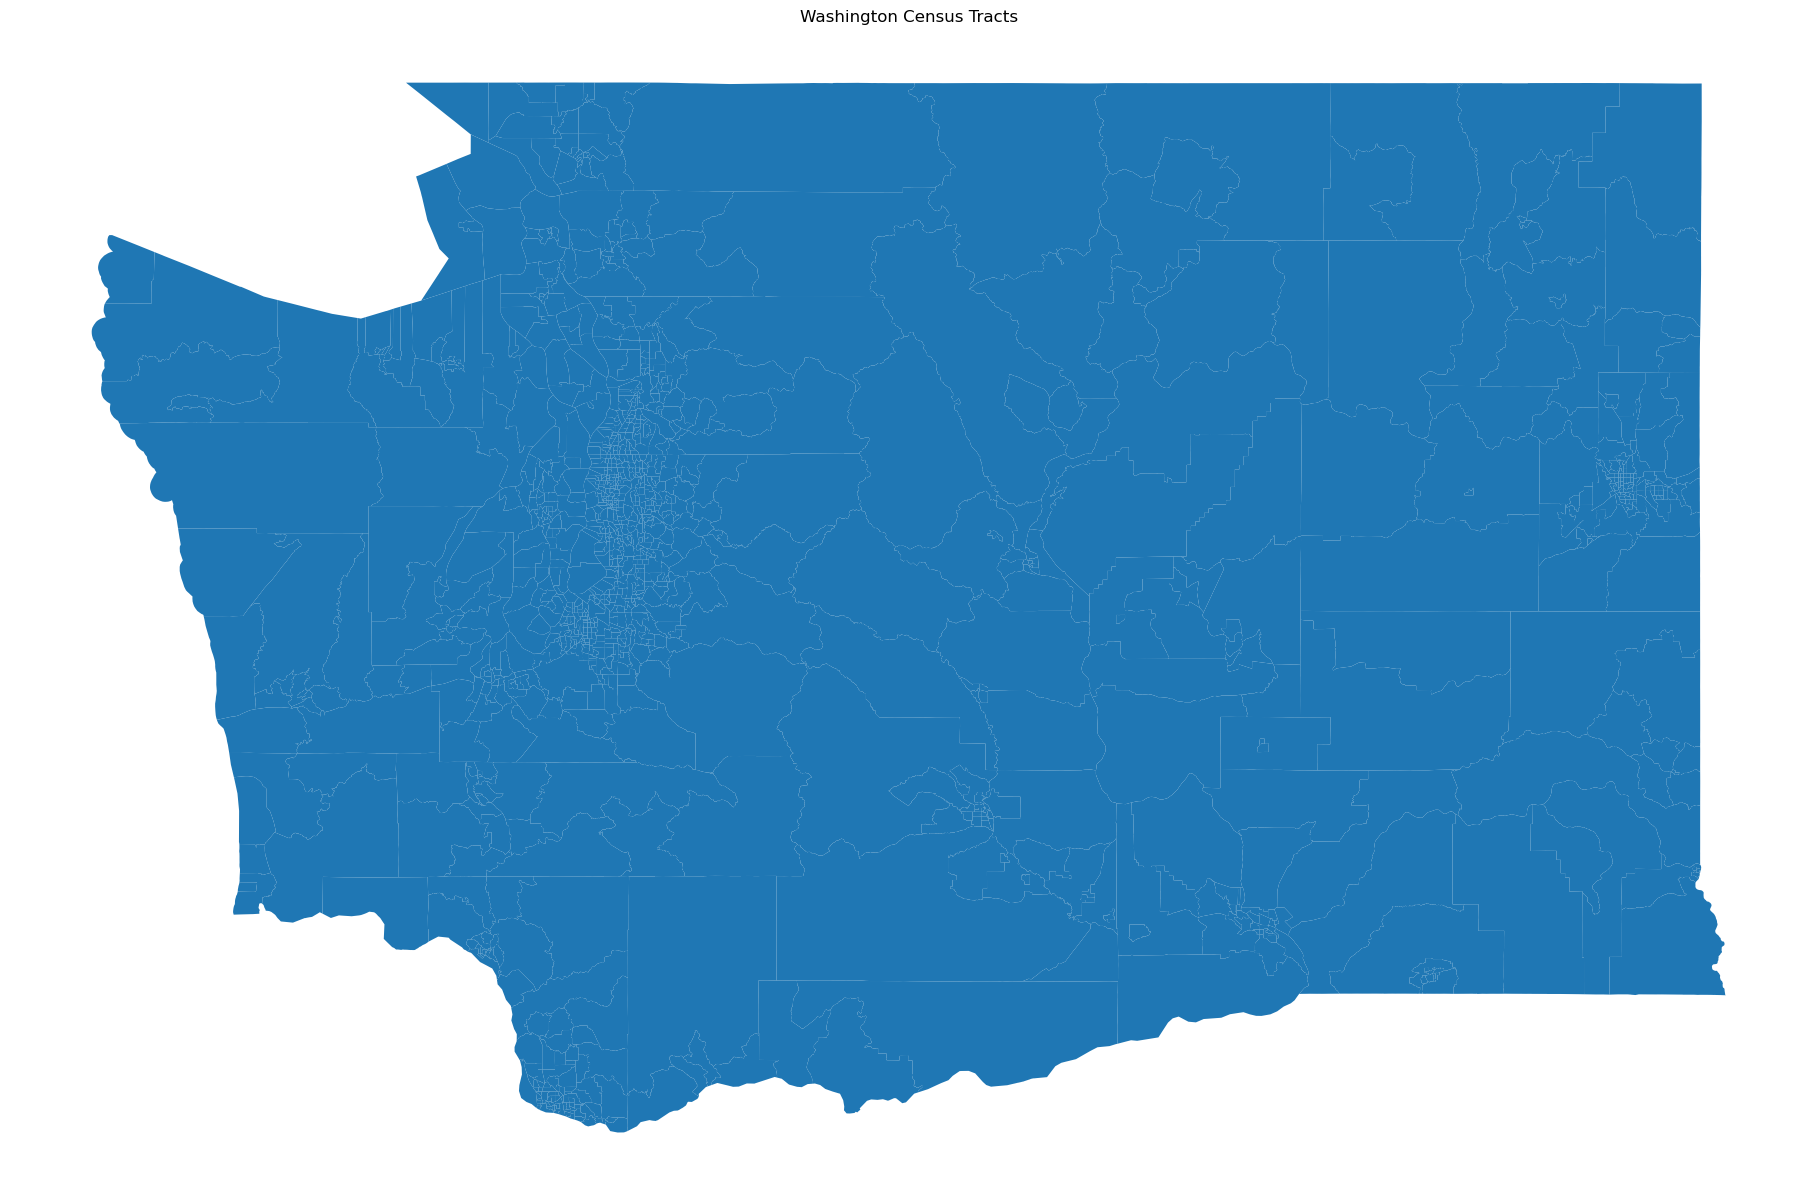

In [3]:
def plot_census_map(state_data):
    """
    This function returns a map that contains the shapes of all the census tracts in Washington
    state with the given merged state dataset.
    """
    fig, ax = plt.subplots(figsize=(35, 15))
    ax.set_title("Washington Census Tracts")
    ax.set_axis_off()
    return state_data.plot(ax=ax)

ax = plot_census_map(state_data)
pcs = ax.findobj(PatchCollection)
assert_patches_allclose(pcs[0], geoms=state_data.geometry)
assert len(pcs) == 1, "unexpected extra plot layers"
assert ax.get_title() == "Washington Census Tracts", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"

When given no arguments, the `dissolve` method considers the entire `GeoDataFrame` as a single group. This will be useful for plotting backgrounds later.

In [12]:
entire_state = state_data[["geometry"]].dissolve()
entire_state

geometry
0  POLYGON ((-122.88260 46.05175, -122.88261 46.0...

## Task: Plot census tract populations

Write a function `plot_census_population_map` that takes the merged data and return the `Axes` that plots all the census tracts in Washington where each census tract is colored according to the `POP2010` column. There will be some missing census tracts. Underneath, plot the entire state of Washington in the background color `#EEE`. Title the plot "Washington Census Tract Populations", turn off axis labels, include a legend, and increase the figure size so that the map is the same height as the legend.

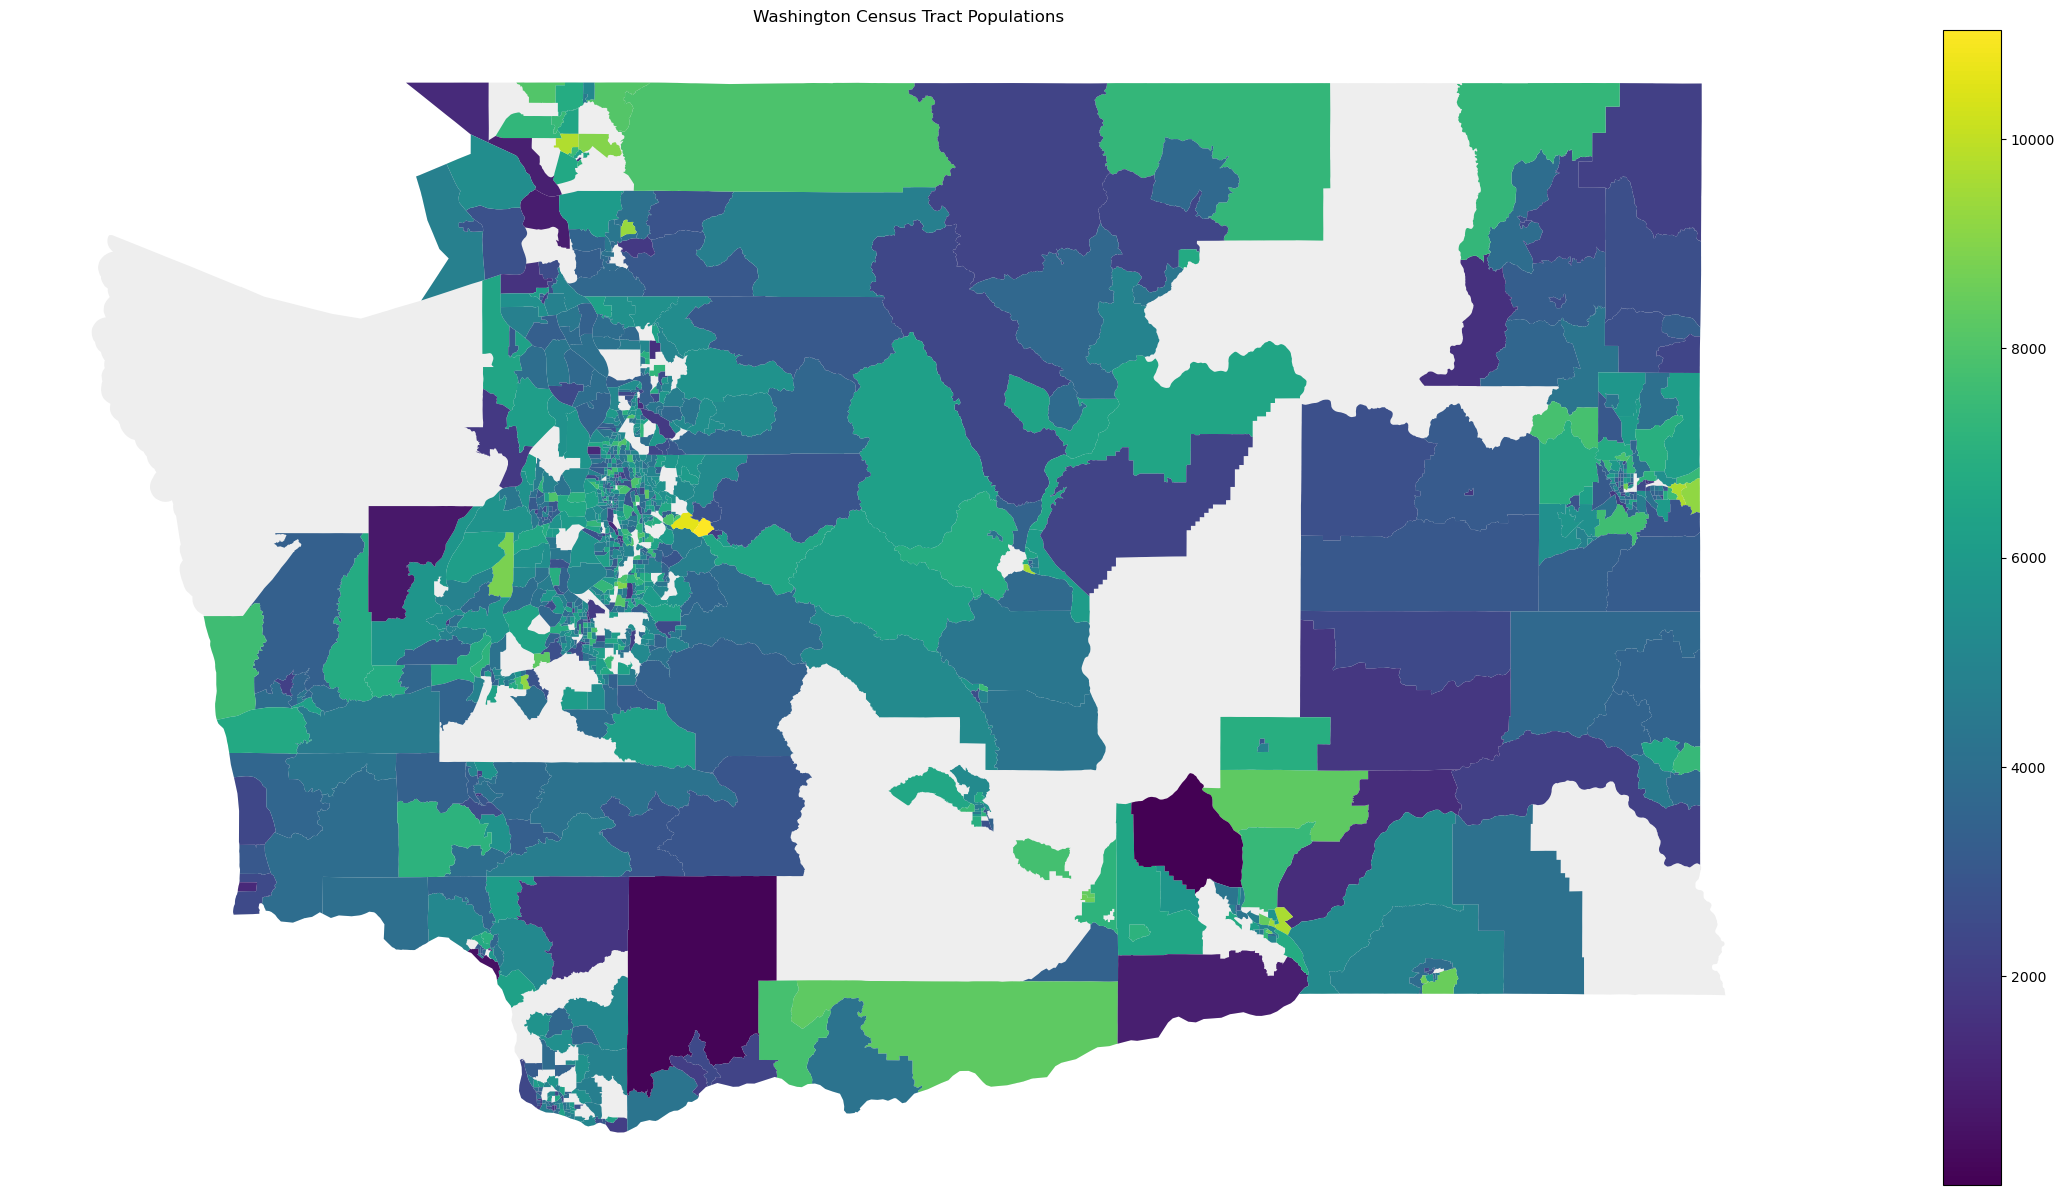

In [17]:
def plot_census_population_map(state_data):
    """
    This function returns a map that plots all the census tracts in Washington state where each
    census tract is colored according to the population with the given merged state dataset. 
    There will be some missing census tracts. 
    """
    fig, ax = plt.subplots(figsize=(35, 15))
    ax.set_title("Washington Census Tract Populations")
    ax.set_axis_off()
    entire_state.plot(ax=ax, color="#EEE")
    return state_data.plot(ax=ax, column="POP2010", legend=True)


ax = plot_census_population_map(state_data)
pcs = ax.findobj(PatchCollection)
assert_patches_allclose(pcs[0], geoms=entire_state.geometry, color="#EEE")
assert_patches_allclose(pcs[1], geoms=state_data.dropna().geometry, num_colors=183)
assert len(pcs) == 2, "unexpected extra plot layers"
assert ax.get_title() == "Washington Census Tract Populations", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"
cbar = ax.get_figure().get_axes()[-1]
assert cbar.get_label() == "<colorbar>", "missing legend"
assert ax.bbox.height == cbar.bbox.height, "map can be enlarged"

## Task: Plot county populations

Write a function `plot_county_populations_map` that takes the merged data and returns the `Axes` that plots all the counties in Washington where each county is colored according to the `POP2010` column. This will require combining all the census tract data and geometries for each county, though there will be missing data for some counties. Underneath, plot the entire state of Washington in the background color `#EEE`. Title the plot "Washington County Populations", turn off axis labels, include a legend, and increase the figure size so that the map is the same height as the legend.

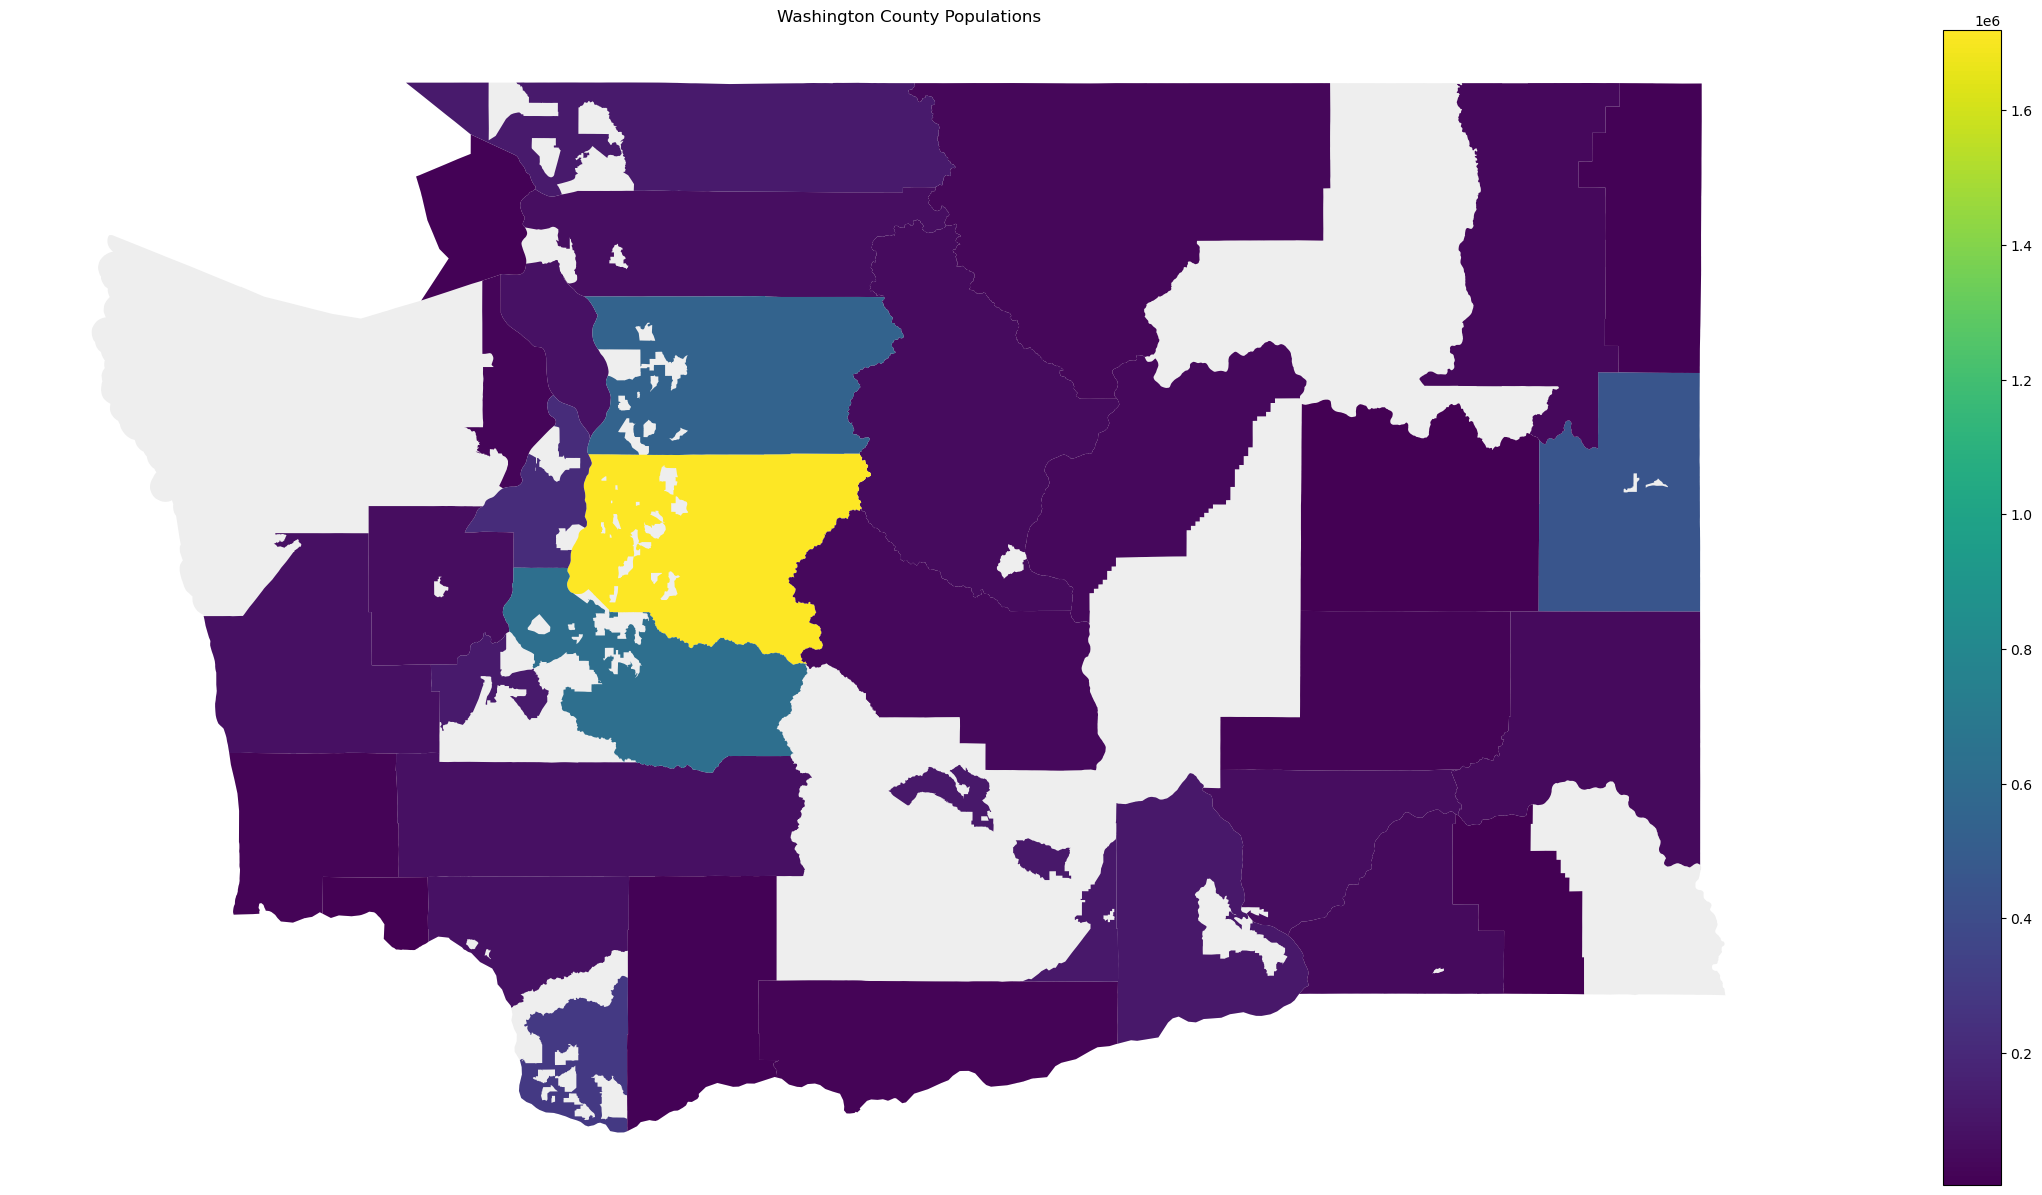

In [6]:
def plot_county_population_map(state_data):
    """
    This function returns a map that plots all the counties in Washington state where each
    county is colored according to the population with the given merged state dataset. Some
    of the counties will have missing data. 
    """
    fig, ax = plt.subplots(figsize=(35, 15))
    ax.set_title("Washington County Populations")
    ax.set_axis_off()
    entire_state.plot(ax=ax, color="#EEE")
    county = state_data.dissolve(by="County", aggfunc="sum")
    return county.plot(ax=ax, column="POP2010", legend=True)


ax = plot_county_population_map(state_data)
pcs = ax.findobj(PatchCollection)
assert_patches_allclose(pcs[0], geoms=entire_state.geometry, color="#EEE")
assert_patches_allclose(pcs[1], geoms="counties.geojson", num_colors=20)
assert len(pcs) == 2, "unexpected extra plot layers"
assert ax.get_title() == "Washington County Populations", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"
cbar = ax.get_figure().get_axes()[-1]
assert cbar.get_label() == "<colorbar>", "missing legend"
assert ax.bbox.height == cbar.bbox.height, "map can be enlarged"

## Task: Plot food access by county

Write a function `plot_food_access_by_county_map` that takes the merged data and returns a 4-tuple of `Axes` that represent the subplots in a 2-by-2 figure consisting of 4 choropleth maps:

- Top left plot titled "Low Access: Half Mile" showing the proportion of people per county who have low access to food within a half mile `lapophalf` out of the total population `POP2010`.
- Top right plot titled "Low Access + Low Income: Half Mile" showing the proportion of people per county considered low income who also have low access to food within a half mile `lalowihalf` out of the total population `POP2010`.
- Bottom left plot titled "Low Access: 10 Miles" showing the proportion of people per county who have low access to food within 10 miles `lapop10` out of the total population `POP2010`.
- Bottom right plot titled "Low Access + Low Income: 10 Miles" showing the proportion of people per county considered low income who also have low access to food within 10 miles `lalowi10` out of the total population `POP2010`.

When calling `plot`, specify the keyword arguments `vmin=0` and `vmax=1` so that the subplots all share the same scale. Underneath, plot the entire state of Washington in the background color `#EEE`. We recommend preparing subplots with `figsize=(15, 10)`. Turn off axis labels on each subplot.

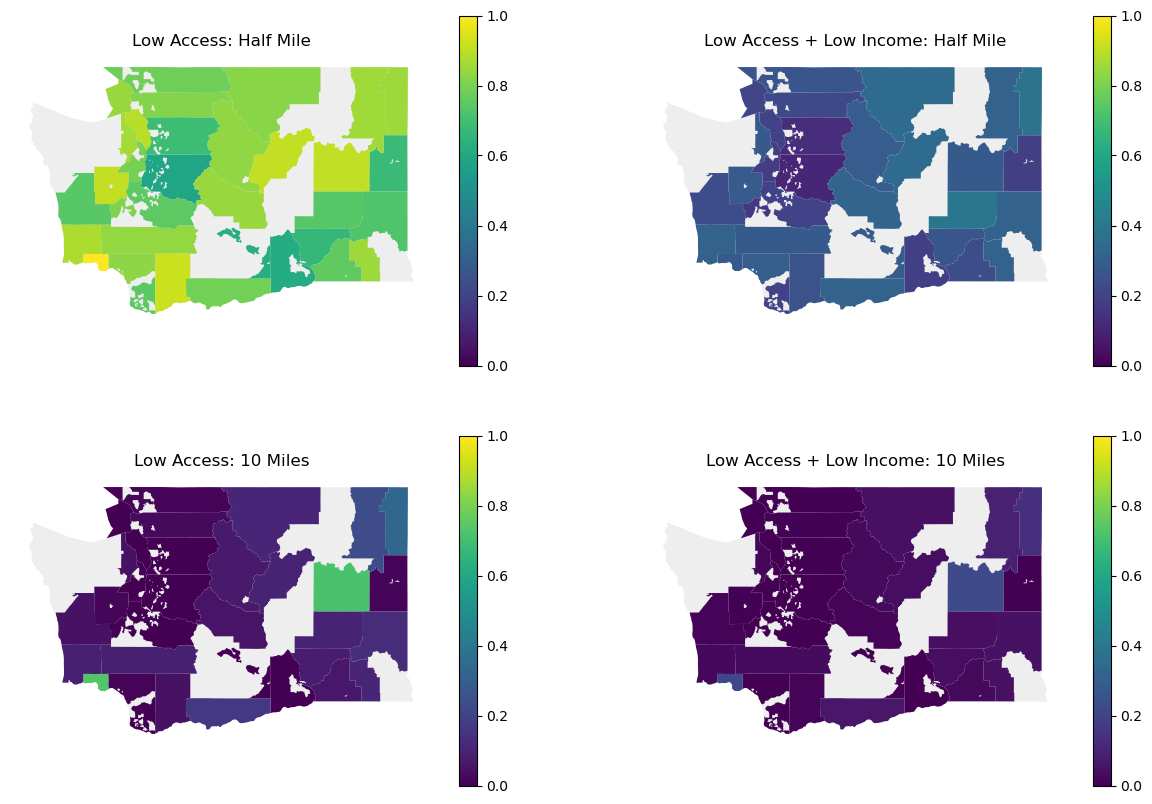

In [7]:
def plot_food_access_by_county_map(state_data):
    """
    This function returns four choropleth maps detailing food access in the given state dataset
    based off four different conditions. One plot looks at low food access within a half mile
    and displays the proportion of people per county who have low access to food within a half
    mile out of the total population while another does the same but at low food access within
    10 miles. One plot looks at low food access and low income and displays the proportion of
    people per county considered low income who also have low access to food within a half mile
    out of the total population while another does the same but at low food access and income
    within 10 miles.
    """
    fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2, figsize=(15, 10))
    titles = ["Low Access: Half Mile", "Low Access + Low Income: Half Mile",
               "Low Access: 10 Miles", "Low Access + Low Income: 10 Miles"]
    columns = ["lapophalf", "lalowihalf", "lapop10", "lalowi10"]
    
    for title, col, ax in zip(titles, columns, [ax1, ax2, ax3, ax4]):
        ax.set_title(title)
        ax.set_axis_off()
        entire_state.plot(ax=ax, color="#EEE")
        county = state_data.dissolve(by="County", aggfunc="sum")
        county[col] /= county["POP2010"]
        county.plot(ax=ax, column=col, legend=True, vmin=0, vmax=1)

    return ax1, ax2, ax3, ax4

        
axs = plot_food_access_by_county_map(state_data)
expected_titles = ["Low Access: Half Mile", "Low Access + Low Income: Half Mile",
                   "Low Access: 10 Miles", "Low Access + Low Income: 10 Miles"]
for ax, expected_num_colors, expected_title in zip(axs, [31, 23, 19, 16], expected_titles):
    pcs = ax.findobj(PatchCollection)
    assert_patches_allclose(pcs[0], geoms=entire_state.geometry, color="#EEE")
    assert_patches_allclose(pcs[1], geoms="counties.geojson", num_colors=expected_num_colors)
    assert len(pcs) == 2, "unexpected extra plot layers"
    assert ax.get_title() == expected_title, f"title {ax.get_title()} does not match expected"
    assert not ax.axison, "borders and labels must be hidden"

## Writeup: Food access by county

Setting aside the lack of a legend in `plot_food_access_by_county_map`, is it an effective visualization? Why or why not?

*I believe that the resulting plots display an effective visualization. The plots clearly display which areas have the highest to lowest proportion of people with low income and/or low food access based off two different distances. It is easy to see that most counties have low food access within half a mile but the majority of them also don't have low food access within 10 miles. It is also easy to see that most counties with low income have 20-40% of low food access among the population within half a mile but the majority of them also don't have low food access and are low income within 10 miles. What we can tell from these plots is that generally there is food access for most counties within 10 miles but it varies within half a mile. It's also seen that most low income counties also have food access within 10 miles but it's at about 30% for within half a mile. Since the plots all have the same scale, I believe it effectively communicates the differences between Washington state counties for different criteria and makes it easy to compare. On the other hand, I can understand why it might not be an effective visualization to others though. The colors tend to be very similar in some areas, especially for both 10 mile plots with the purple being very dominant and blending it together pretty well. This could be difficult to understand for some since the colors here are too close and makes it a little confusing, so a multitude of colors being used could possibly make this visualization even better. Also, a legend will definitely make it a lot better so it is easier to understand what exacty we are looking at in the plots and what the different colors mean.*

## Task: Plot low access census tracts

Write a function `plot_census_low_access_map` that takes the merged data and returns the `Axes` that plots all census tracts (not counties) considered low access using 5 `plot` layers for the following definitions for "low access" in urban and rural tracts. For this task, do not use the `LATracts_half` or `LATracts10` columns in the merged data; the procedure described below intentionally results in different values.

1. Plot the map of Washington in the background with color `#EEE`.

1. Plot all the `Urban` and `Rural` census tracts for which we have food access data in the color `#AAA`.

1. Plot all the `Urban` and `Rural` census tracts considered low access in the default (blue) color.

   **Low access in an urban census tract** is defined by a `lapophalf` value that is at least 500 people or at least 33% of the census tract population.

   **Low access in a rural census tract** is defined by a `lapop10` value that is at least 500 people or at least 33% of the census tract population.

Finally, title the plot "Low Access Census Tracts" and turn off axis labels.

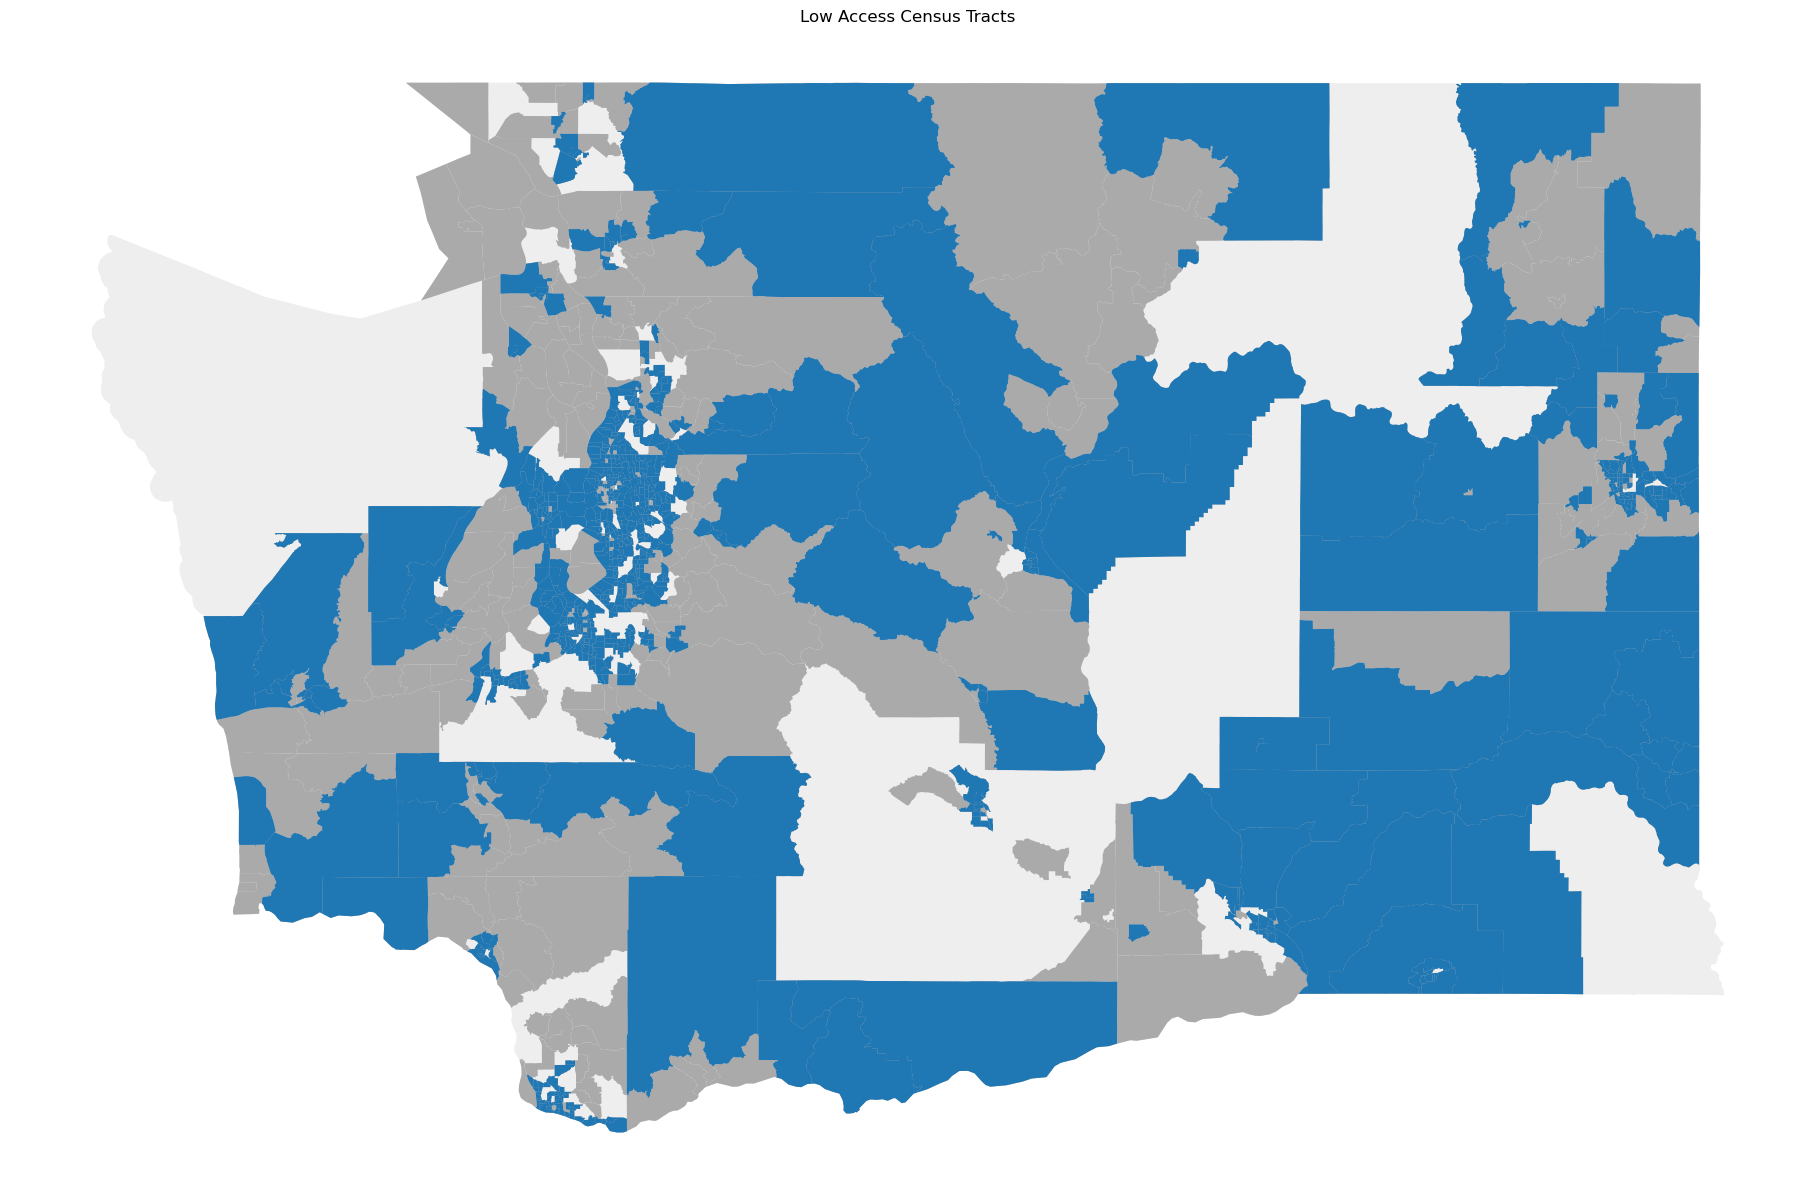

In [8]:
def plot_census_low_access_map(state_data):
    """
    This function returns a map that plots all census tracts considered low access in urban
    and rural tracts with the given state dataset. Low access in an urban census tract is 
    defined by a population of 500 people or at least 33% of the census tract population.
    The same criteria applies for what is considered low access in a rural area.
    """
    fig, ax = plt.subplots(figsize=(35, 15))
    ax.set_title("Low Access Census Tracts")
    ax.set_axis_off()
    entire_state.plot(ax=ax, color="#EEE")
    
    state_data[state_data["Urban"] == 1].plot(ax=ax, color="#AAA")
    state_data[state_data["Rural"] == 1].plot(ax=ax, color="#AAA")
    
    urban = (state_data["Urban"] == 1) & ((state_data["lapophalf"] >= 500) |
                (state_data["lapophalf"] / state_data["POP2010"] >= 0.33))
    rural = (state_data["Rural"] == 1) & ((state_data["lapop10"] >= 500) |
                (state_data["lapop10"] / state_data["POP2010"] >= 0.33))
    
    state_data[urban].plot(ax=ax)
    state_data[rural].plot(ax=ax)
    return ax

ax = plot_census_low_access_map(state_data)
pcs = ax.findobj(PatchCollection)
assert_patches_allclose(pcs[0], geoms=entire_state.geometry, color="#EEE")
urban_idx = state_data["Urban"].notna() & ~state_data.index.isin(rural_idx)
urban_la_idx = urban_idx & ~state_data.index.isin(urban_ha_idx)
error = None
for i, j, k, l in [
    [1, 2, 3, 4], # urban, rural, urban low access, rural low access
    [2, 1, 3, 4], # rural, urban, urban low access, rural low access
    [1, 2, 4, 3], # urban, rural, rural low access, urban low access
    [2, 1, 4, 3], # rural, urban, rural low access, urban low access
    [1, 3, 2, 4], # urban, urban low access, rural, rural low access
    [3, 1, 4, 2], # rural, rural low access, urban, urban low access
]:
    try:
        assert_patches_allclose(pcs[i], geoms=state_data.loc[urban_idx, "geometry"], color="#AAA")
        assert_patches_allclose(pcs[j], geoms=state_data.loc[rural_idx, "geometry"], color="#AAA")
        assert_patches_allclose(pcs[k], geoms=state_data.loc[urban_la_idx, "geometry"])
        assert_patches_allclose(pcs[l], geoms=state_data.loc[rural_la_idx, "geometry"])
        break
    except AssertionError as e:
        if error is None: # Store only the first error encountered during testing
            error = e
else: # Only raise an error if none of the possible ways to layer the plot worked
    raise error
assert len(pcs) == 5, "unexpected extra plot layers"
assert ax.get_title() == "Low Access Census Tracts", "title does not match expected"
assert not ax.axison, "borders and labels must be hidden"

## Writeup: Data-driven decision-making

What is one way that government or food access organizations could use `plot_food_access_by_county` or `plot_low_access_tracts` to shape their decisions or policies? Then, explain one limitation or concern with using the plots in the way you suggested.

*The function plot_access_by_county displays food access by distance and on whether it's low income or not while the function plot_low_access_tracts displays the census tracts seen as low access. Both are pretty similar in what they display with the former detailing the counties more specifically by incorporating population into the data. The government or food access organizations could use the data from these graphs to identify which areas have the highest proportion of residents facing the lowest food access and require to most help. This could help them allocate more resources to these areas such as food assistance programs in order to improve food access. Everyone should be able to easily access food and by identifying areas that need the most support will allow more people to have food access. A limitation that could arise from this though is that the plot_food_access_by_county function looks at food access within certain distances and this might not encapsulate all issues that cause the low food access. Food access in these low access areas could have been limited by transportation to get to food places or by types of food access location such as a grocery store, farmer's market, etc. Food preferences could also play a role with what types of food certain populations are able to eat and this is something that can't be determined from the plots generated and requires more context and analysis. Generally, the plots will be great in identifying areas with lowest food access but it won't be as helpful when looking into the underlying issues that cause these food access issues and what could be done to remedy specific problems.*

## Task: Interactive map

Although the initial report to Congress was completed in June 2009, the Economic Research Service has since then maintained an interactive map for their [**Food Access Research Atlas**](https://gisportal.ers.usda.gov/ers/GIS_FARA/lowincome_lowaccess.html). Open this interactive map, turn off the default layer "LI and LA and 1 and 10 miles", and turn on the layer "LI and LA at 1/2 and 10 miles". This layer displays:

> Low-income census tracts where a significant number or share of residents is more than 1/2 mile (urban) or 10 miles (rural) from the nearest supermarket.

Write a function `interactive_map` that returns a Folium `Map` of low income and low access census tracts in Washington. Include only `LowIncomeTracts` that are either low access at half a mile `LATracts_half` or low access at 10 miles `LATracts10` depending on whether the census tract is `Urban` or `Rural`, respectively. This dataset does not match the Food Access Research Atlas, so some differences are to be expected. It is also OK if your interactive map does not appear in the PDF printout as PDF files cannot embed interactive maps.

In [9]:
def interactive_map(state_data):
    """
    This functions returns an interactive map of low income and low access census tracts in
    Washington state with the given state data. The low income tracts included are either low
    access at half a mile or low access at 10 miles. This depends on whether the census tract
    is urban or rural, respectively.
    """
    low_income = state_data["LowIncomeTracts"] == 1
    urban = state_data["Urban"] == 1
    rural = state_data["Rural"] == 1
    
    low_access = state_data[low_income & (urban & (state_data["LATracts_half"] == 1) |
                                          rural & (state_data["LATracts10"] == 1))]
    return low_access.explore()

map = interactive_map(state_data)
display(map)
geojson = next(reversed(map._children.values())).data
assert [int(d["id"]) for d in geojson["features"]] == lalowi_idx, "wrong selection"

## Writeup: Build a new supermarket

Using the interactive map above, locate the low-income low-access census tract closest to your favorite place in Washington. Then, identify a location (a specific street intersection, such as "University Way NE & NE 45th St") to add a new supermarket that would serve the people living in that census tract. Finally, explain the considerations that factored into your choice of location.

This dataset is outdated, so assume there are no supermarkets in any low-income low-access census tract even if supermarkets are present today.

*I would consider 37th Avenue South & South 188th Street to be a good location to build a new supermarket. This location was chosen as it is in a low census tract and close to other low census tracts and is within a residential area and close to the SeaTac airport. There are plenty of schools in this area and this street seems to be a main road in this residential area, not a neighborhood road. Since this area is near other low access census tracts, it will ensure more of the population has access to food. It being in a residential area will also allow more residents of that area to have convenient food access. Additionally, since it's a road that passes along a school in that area with more schools closeby and is like a main road, it can be easily accessible to residents and commuters. There being schools in the area also suggests more families live in this area that will have higher food demands and it makes it more easy for parent and students to hace access to fresh and healthy food options. The closeness to the airport also allows for another avenue of customers since there are hotels near this area as well so hotel guests and airport guests/workers have closer food access. 37th Avenue South & South 188th Street appears to have good prospects due to it's location, demographic, and accessibility which is why I chose it.*